# Distributed Gaussian Process Models
*Blaine Rogers &lt;<br1314@ic.ac.uk>&gt; 25-09-2016*

In this notebook, we explore the classes in the `gptf.distributed` and use them to replicate some of the results in [Deisenroth and Ng's 2015 paper][dgppaper]. We'll start by creating some sample data, some test points, and training a reference GP to test against.

[dgppaper]: http://jmlr.org/proceedings/papers/v37/deisenroth15.pdf

In [1]:
from IPython.display import display_html
import gptf
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

full_gp = gptf.gpr.GPR(
    gptf.kernels.RBF(variance=10.),
    noise_variance=.25
)
X = np.random.uniform(0., 5., (20, 1))
Y = full_gp.compute_prior_samples(X, 1, 1)[0]
Y += np.random.normal(0., np.sqrt(full_gp.likelihood.variance.value),
                      Y.shape)  # add noise
full_gp.optimize(X, Y, disp=False)
display_html(full_gp.summary(fmt='html'), raw=True)

Parameterized object full_gp 
 Params 
 
 
 name 
 value 
 transform 
 prior 
 
 
 full_gp.kernel. lengthscales 
 1.127 
 +ve (Exp) 
 nyi 
 
 
 full_gp.kernel. variance 
 4.755 
 +ve (Exp) 
 nyi 
 
 
 full_gp.likelihood. variance 
 0.194 
 +ve (Exp) 
 nyi

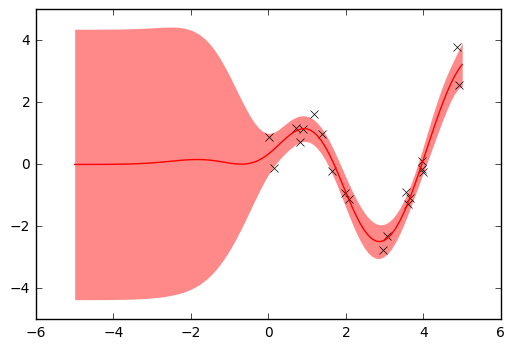

In [2]:
test_points = np.linspace(-5, 5, 100).reshape(-1, 1)
full_gp_mean, full_gp_var =\
    full_gp.compute_posterior_mean_var(X, Y, test_points)
full_gp_mean = full_gp_mean[:, 0]
full_gp_var = full_gp_var[:, 0]
full_gp_sigma = np.sqrt(full_gp_var)
plt.plot(X, Y, 'kx')
plt.plot(test_points[:, 0], full_gp_mean, 'r-')
plt.fill_between(test_points[:,0], 
                 full_gp_mean + 2*full_gp_sigma,
                 full_gp_mean - 2*full_gp_sigma,
                 color='#ff8888', linewidth=.0)
plt.show()

We're now ready to start experimenting with the distributed models. We'll start by creating ten expert models that share their parameters. To best demonstrate the differences between the models, we'll use the parameters from the reference gp. The reduction classes distribute the data evenly between their experts, so each expert will see two data points.

In [3]:
template_expert = gptf.gpr.GPR(gptf.kernels.RBF())
template_expert.kernel.variance = full_gp.kernel.variance.value
template_expert.kernel.lengthscales = full_gp.kernel.lengthscales.value
template_expert.likelihood.variance = full_gp.likelihood.variance.value

experts = [template_expert] * 10

def plot_posterior_mean_var_against_full_gp(axis, mean, var):
    axis.fill_between(test_points[:,0], 
                      full_gp_mean + 2*full_gp_sigma,
                      full_gp_mean - 2*full_gp_sigma,
                      color='#cccccc', linewidth=.0)
    axis.plot(X, Y, 'k.')
    mean, var = mean[:, 0], var[:, 0]
    sigma = np.sqrt(var)
    axis.plot(test_points[:, 0], mean, 'r-',
              test_points[:, 0], mean + 2*sigma, 'r--',
              test_points[:, 0], mean - 2*sigma, 'r--')

We can "reduce" these experts using reduction classes in `gptf.distributed`. The reduction classes handle splitting the data amongst the experts, then combining the experts' independent predictions. We'll start by looking at the Product of Experts (PoE) model.

## Product of Experts

The product-of-GP-experts model predicts a function value
$f_\star$ at a corresponding test input $x_\star$ according to

$$p(f_\star\ \vert\ x_\star, \mathcal{D})\ =\ 
  \prod_{k=1}^{M} p_k(f_\star\ \vert\ x_\star, \mathcal{D}^{(k)})$$
  
where $M$ GP experts operate on different training data subsets
$\mathcal{D}^{(k)}$. For $M = 1$, this is identical to the full
GP that we wish to approximate.

A shortcoming of this model is that with an increasing number of 
GP experts the predictive variances vanish,
which leads to overconfident predictions, especially in regions
without data. Thus, the PoE model is inconsistent in
the sense that it does not fall back to the prior, as can be seen
in the generated graph.

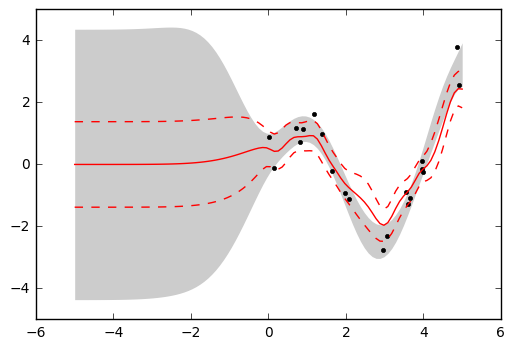

In [4]:
poe = gptf.distributed.PoEReduction(experts)
poe_mean, poe_var = poe.compute_posterior_mean_var(X, Y, test_points)
plot_posterior_mean_var_against_full_gp(plt, poe_mean, poe_var)
plt.show()

## Generalised Product of Experts

The generalised product-of-experts model (gPoE) by [Cao
& Fleet (2014)][caofleet2014] adds the flexibility of 
increasing/reducing the importance of experts. The predictive 
distribution is

$$p(f_\star\ \vert\ x_\star, \mathcal{D})\ =\ 
  \prod_{k=1}^M p_k^{\beta_k}(f_\star\ \vert\ x_\star, 
  \mathcal{D}^{(k)})$$
  
where the $\beta_k$ weight the contributions of the experts.

A strength of the gPoE is that with $\sum_k \beta_k = 1$ 
the model falls back to the prior outside the range of the
data. A weakness of the gPoE is that in the range of
the data, it over-estimates the variances, i.e., the predictions
are generally too conservative, especially with an increasing
number of GP experts. 

[caofleet2014]: http://arxiv.org/abs/1410.7827

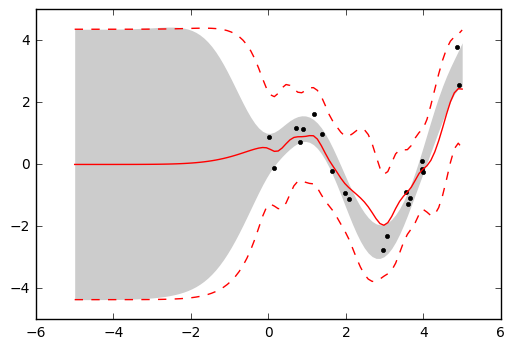

In [5]:
gpoe = gptf.distributed.gPoEReduction(
    experts,
    gptf.distributed.equal_weights
)

gpoe_mean, gpoe_var = gpoe.compute_posterior_mean_var(X, Y, test_points)
plot_posterior_mean_var_against_full_gp(plt, gpoe_mean, gpoe_var)
plt.show()

## Bayesian Committee Machine

A third model that falls in the category of PoE models is the
Bayesian Committee Machine (BCM) proposed by 
[Tresp (2000)][tresp2000]. Unlike the (g)PoE, 
the BCM explicitly incorporates the GP prior $p(f)$ 
when combining predictions (and not only at the leaves). Its
posterior predictive distribution is

$$p(f_\star\ \vert\ x_\star, \mathcal{D}) =
  \frac{\prod_{k=1}^M p_k(f_\star\ \vert\ x_\star, \mathcal{D}^{(k)})}
       {p^{M - 1}(f_\star\ \vert\ x_\star)}$$
       
The $(M − 1)$-fold division by the prior plays the
role of a "correction" term that ensures a consistent
model that falls back to the prior. The error bars of the
BCM within the range of the data are usually good, but it
is possible to "break" the BCM when only few data points
are assigned to each GP expert, as is the case here. In the
generated graph, we see that the bcm suffers from weak experts
when leaving the data.

[tresp2000]: http://www.dbs.ifi.lmu.de/˜tresp/papers/bcm6.pdf

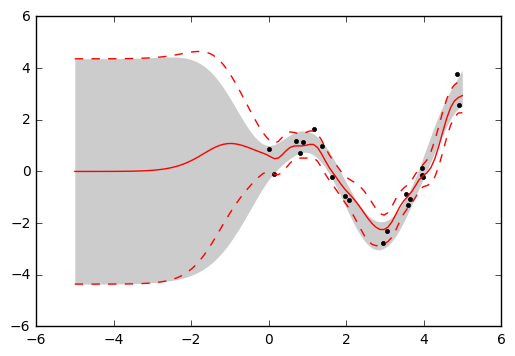

In [6]:
bcm = gptf.distributed.BCMReduction(experts)
bcm_mean, bcm_var = bcm.compute_posterior_mean_var(X, Y, test_points)
plot_posterior_mean_var_against_full_gp(plt, bcm_mean, bcm_var)
plt.show()

## Robust Bayesian Committee Machine

Inspired by the gPoE, the rBCM is a BCM with the
added flexibility of increasing/decreasing an expert’s importance.
The rBCM’s predictive distribution is

$$p(f_\star\ \vert\ x_\star, \mathcal{D}) =
  \frac{\prod_{k=1}^M p_k^{\beta_k}(f_\star\ \vert\ x_\star, \mathcal{D}^{(k)})}
       {p^{−1+\sum_k \beta_k}(f_\star\ \vert\ x_\star)}$$
       
The rBCM combines the flexibility of the generalised
PoE with the appropriate Bayesian treatment of the BCM.
Its predictive variance falls back to the prior when 
leaving the data, and we no longer require 
$\sum_k \beta_k = 1$ to ensure this.
The gPoE and the BCM are recovered for $\beta_k = \frac{1}{M}$ 
and $\beta_k = 1$, respectively. For $\beta_k = 0$,
the rBCM is identical to the GP prior. Below, we choose
$\beta_k$ according to the predictive power of each
expert at $x_\star$, as suggested by [Cao & Fleet (2014)][caofleet2014].

[caofleet2014]: http://arxiv.org/abs/1410.7827

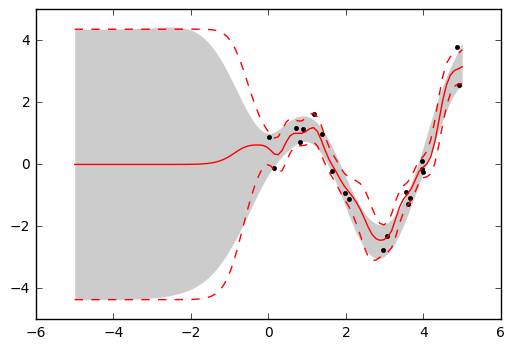

In [7]:
rbcm = gptf.distributed.rBCMReduction(
    experts,
    gptf.distributed.cao_fleet_weights
)

rbcm_mean, rbcm_var = rbcm.compute_posterior_mean_var(X, Y, test_points)
plot_posterior_mean_var_against_full_gp(plt, rbcm_mean, rbcm_var)
plt.show()

## Side-by-side comparison

Below, we produce something similar to Figure 2 from 
[Deisenroth & Ng (2015)][distpaper], which provides us with a side-by-side
comparision of the various models.

[distpaper]: http://jmlr.org/proceedings/papers/v37/deisenroth15.pdf

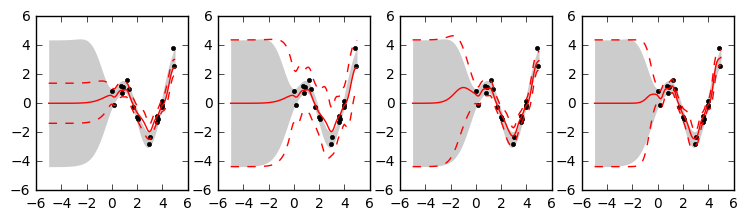

In [8]:
plt.figure(figsize=(9, 2.25))
axes = plt.subplot(141)
plot_posterior_mean_var_against_full_gp(plt, poe_mean, poe_var)
plt.subplot(142, sharey=axes)
plot_posterior_mean_var_against_full_gp(plt, gpoe_mean, gpoe_var)
plt.subplot(143, sharey=axes)
plot_posterior_mean_var_against_full_gp(plt, bcm_mean, bcm_var)
plt.subplot(144, sharey=axes)
plot_posterior_mean_var_against_full_gp(plt, rbcm_mean, rbcm_var)
plt.show()

## Time concerns

Below, we demonstrate that the distributed GP models can be trained much faster than regular GPs.

In [ ]:
full_gp = gptf.gpr.GPR(
    gptf.kernels.RBF(
        variance=10.,
        lengthscales=3.,
    ),
    noise_variance=.5
)

expert = gptf.gpr.GPR(
    gptf.kernels.RBF(
        variance=10.,
        lengthscales=3.,
    ),
    noise_variance=.5
)

experts = [expert.copy() for _ in range(100)]
rbcm = gptf.distributed.rBCMReduction(
    experts, gptf.distributed.cao_fleet_weights
)

X = np.random.uniform(0., 100., (10000, 3))
Y = full_gp.compute_prior_samples(X, 1, 1)[0]
sigma = np.sqrt(full_gp.likelihood.variance.value)
Y += np.random.normal(0., sigma, Y.shape)

def optimise_and_predict(gp):
    gp.optimize(X, Y, disp=False)
    return gp.compute_posterior_mean_var(X, Y, test_points)

print("Time for full GP:")
%time full_gp_mean, full_gp_var \
    = optimise_and_predict(full_gp)

print("Time for rBCM:")
%time rbcm_mean, rbcm_var \
    = optimise_and_predict(rbcm)

plt.figure(figsize=(9, 4.5))
axes = plt.subplot(121)
plt.plot(X, Y, 'kx',
         test_points, full_gp_mean, 'r-')
plt.fill_between(test_points[:, 0],
                 (full_gp_mean+full_gp_var)[:, 0],
                 (full_gp_mean-full_gp_var)[:, 0],
                 color='#ffaaaa', linewidth=0.)
plt.subplot(122, sharey=axes)
plt.plot(X, Y, 'kx',
         test_points, rbcm_mean, 'r-')
plt.fill_between(test_points[:, 0],
                 (rbcm_mean+rbcm_var)[:, 0],
                 (rbcm_mean-rbcm_var)[:, 0],
                 color='#ffaaaa', linewidth=0.)
plt.show()